## **Dataset**

In [1]:
from datasets import load_from_disk

ds = load_from_disk("/root/mems_dataset")


/miniconda3/envs/dppo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# get only 100 random samples
ds = ds.shuffle(seed=42).select(range(100))

In [16]:
import os
model = os.path.join("/root/.cache/huggingface/hub/model/text_encoder", "text_eer")
model

'/root/.cache/huggingface/hub/model/text_encoder/text_eer'

In [24]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
text_encoder = CLIPTextModel.from_pretrained("/root/.cache/modelscope/hub/models/openai-mirror/clip-vit-base-patch16").to(device)
text_encoder.eval()
tokenizer = CLIPTokenizer.from_pretrained("/root/.cache/modelscope/hub/models/openai-mirror/clip-vit-base-patch16")

In [25]:
ds["text"][0]

'drive_freq:42000Hz,split:between_0.5%_and_1.0%,parasitic:berween_5000_and_10000Hz,x_stiffness:7300N/m,nonlinearity:moderate'

In [26]:
# ds["image"][0]

In [6]:
# ds["image"][0].save("text_to_image.png", format="PNG")

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CFMDataset(Dataset):
    def __init__(self, dataset, text_encoder, tokenizer, device):
        self.dataset = dataset
        self.transform = transforms.Compose(
            [transforms.Resize((64, 64)), transforms.ToTensor()]
            
        )
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.device = device
        self.images = dataset["image"]
        self.captions = dataset["text"]
        self.cache = {}

    def get_embed(self, caption):
        inputs = self.tokenizer(
            caption,
            truncation=True,
            padding=True,
            return_tensors="pt"
        ).to(self.device)
        self.text_encoder.eval()
        with torch.no_grad():
            # Use mean pooling instead of just the first token
            text_features = self.text_encoder(**inputs).last_hidden_state
            # Mean pooling
            text_features = text_features.mean(dim=1)
        return text_features.squeeze(0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]

        transformed_image = self.transform(self.images[idx])
        caption = self.captions[idx]
        caption_embedding = self.get_embed(caption)

        item = {
            "image": transformed_image,
            "caption": caption,
            "caption_embedding": caption_embedding,
        }

        self.cache[idx] = item
        return item

In [29]:
train_ds = CFMDataset(ds, text_encoder, tokenizer, device)
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True)

## **Model**

In [32]:
import math
import torch.nn as nn
from torchcfm.models.unet import UNetModel

def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period)
        * torch.arange(start=0, end=half, dtype=torch.float32, device=timesteps.device)
        / half
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class UNetModelWithTextEmbedding(UNetModel):
    def __init__(self, dim, num_channels, num_res_blocks, embedding_dim, *args, **kwargs):
        super().__init__(dim, num_channels, num_res_blocks, *args, **kwargs)

        self.embedding_layer = nn.Linear(embedding_dim, num_channels*4)
        self.fc = nn.Linear(num_channels*8, num_channels*4)

    def forward(self, t, x, text_embeddings=None):
        """Apply the model to an input batch, incorporating text embeddings."""
        timesteps = t

        while timesteps.dim() > 1:
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(
            timestep_embedding(timesteps, self.model_channels)
        )

        if text_embeddings is not None:
            text_embedded = self.embedding_layer(text_embeddings)
            emb = torch.cat([emb, text_embedded], dim=1) # 128*2
            emb = self.fc(emb)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)

## **Training**

In [33]:
model = UNetModelWithTextEmbedding(
    dim=(3, 64, 64), num_channels=64, num_res_blocks=1, embedding_dim=512, dropout=0.05, num_heads=4
).to(device)
optimizer = torch.optim.AdamW(model.parameters())

In [34]:
from tqdm import tqdm

n_epochs = 10000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

for epoch in tqdm(range(n_epochs)):
    losses = []
    for batch in train_loader:
        optimizer.zero_grad()
        x1 = batch["image"].to(device)
        text_embeddings = batch["caption_embedding"].to(device)

        x0 = torch.randn_like(x1).to(device)

        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1 + (1 - t) * x0
        ut = x1 - x0

        t = t.squeeze()

        vt = model(t, xt, text_embeddings=text_embeddings)

        loss = torch.mean(((vt - ut) ** 2))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

  1%|          | 100/10000 [00:45<1:00:49,  2.71it/s]

Epoch [100/10000], Loss: 0.0316


  2%|▏         | 200/10000 [01:24<1:09:34,  2.35it/s]

Epoch [200/10000], Loss: 0.0186


  3%|▎         | 300/10000 [02:07<1:09:23,  2.33it/s]

Epoch [300/10000], Loss: 0.0157


  4%|▍         | 400/10000 [02:50<1:09:14,  2.31it/s]

Epoch [400/10000], Loss: 0.0154


  5%|▌         | 500/10000 [03:33<1:07:06,  2.36it/s]

Epoch [500/10000], Loss: 0.0155


  6%|▌         | 600/10000 [04:16<1:06:21,  2.36it/s]

Epoch [600/10000], Loss: 0.0123


  7%|▋         | 700/10000 [04:58<1:05:40,  2.36it/s]

Epoch [700/10000], Loss: 0.0120


  8%|▊         | 800/10000 [05:41<1:05:18,  2.35it/s]

Epoch [800/10000], Loss: 0.0161


  9%|▉         | 900/10000 [06:24<1:04:00,  2.37it/s]

Epoch [900/10000], Loss: 0.0099


 10%|█         | 1000/10000 [07:06<1:05:19,  2.30it/s]

Epoch [1000/10000], Loss: 0.0219


 11%|█         | 1100/10000 [07:50<1:04:30,  2.30it/s]

Epoch [1100/10000], Loss: 0.0140


 12%|█▏        | 1200/10000 [08:33<1:04:06,  2.29it/s]

Epoch [1200/10000], Loss: 0.0115


 13%|█▎        | 1300/10000 [09:16<1:01:06,  2.37it/s]

Epoch [1300/10000], Loss: 0.0100


 14%|█▍        | 1400/10000 [09:58<1:00:48,  2.36it/s]

Epoch [1400/10000], Loss: 0.0090


 15%|█▌        | 1500/10000 [10:40<1:00:20,  2.35it/s]

Epoch [1500/10000], Loss: 0.0095


 16%|█▌        | 1600/10000 [11:23<59:32,  2.35it/s]  

Epoch [1600/10000], Loss: 0.0059


 17%|█▋        | 1700/10000 [12:06<59:17,  2.33it/s]  

Epoch [1700/10000], Loss: 0.0066


 18%|█▊        | 1800/10000 [12:48<57:57,  2.36it/s]

Epoch [1800/10000], Loss: 0.0107


 19%|█▉        | 1900/10000 [13:31<57:27,  2.35it/s]

Epoch [1900/10000], Loss: 0.0059


 20%|██        | 2000/10000 [14:13<56:07,  2.38it/s]

Epoch [2000/10000], Loss: 0.0026


 21%|██        | 2100/10000 [14:56<55:28,  2.37it/s]

Epoch [2100/10000], Loss: 0.0034


 22%|██▏       | 2200/10000 [15:38<55:16,  2.35it/s]

Epoch [2200/10000], Loss: 0.0083


 23%|██▎       | 2300/10000 [16:21<54:22,  2.36it/s]

Epoch [2300/10000], Loss: 0.0032


 24%|██▍       | 2400/10000 [17:03<53:30,  2.37it/s]

Epoch [2400/10000], Loss: 0.0068


 25%|██▌       | 2500/10000 [17:46<53:14,  2.35it/s]

Epoch [2500/10000], Loss: 0.0042


 26%|██▌       | 2600/10000 [18:28<52:05,  2.37it/s]

Epoch [2600/10000], Loss: 0.0021


 27%|██▋       | 2700/10000 [19:11<51:39,  2.36it/s]

Epoch [2700/10000], Loss: 0.0066


 28%|██▊       | 2800/10000 [19:53<50:46,  2.36it/s]

Epoch [2800/10000], Loss: 1.0352


 29%|██▉       | 2900/10000 [20:35<49:44,  2.38it/s]

Epoch [2900/10000], Loss: 1.0228


 30%|███       | 3000/10000 [21:17<48:51,  2.39it/s]

Epoch [3000/10000], Loss: 1.0142


 31%|███       | 3100/10000 [21:59<48:49,  2.36it/s]

Epoch [3100/10000], Loss: 1.0124


 32%|███▏      | 3200/10000 [22:41<48:06,  2.36it/s]

Epoch [3200/10000], Loss: 1.0023


 33%|███▎      | 3300/10000 [23:24<47:05,  2.37it/s]

Epoch [3300/10000], Loss: 0.9962


 34%|███▍      | 3400/10000 [24:06<46:26,  2.37it/s]

Epoch [3400/10000], Loss: 0.9898


 35%|███▌      | 3500/10000 [24:48<46:05,  2.35it/s]

Epoch [3500/10000], Loss: 0.9761


 36%|███▌      | 3600/10000 [25:30<44:51,  2.38it/s]

Epoch [3600/10000], Loss: 0.9504


 37%|███▋      | 3700/10000 [26:13<44:29,  2.36it/s]

Epoch [3700/10000], Loss: 0.8173


 38%|███▊      | 3800/10000 [26:55<43:16,  2.39it/s]

Epoch [3800/10000], Loss: 1.0226


 39%|███▉      | 3900/10000 [27:37<44:01,  2.31it/s]

Epoch [3900/10000], Loss: 1.0135


 40%|████      | 4000/10000 [28:20<43:20,  2.31it/s]

Epoch [4000/10000], Loss: 1.0080


 41%|████      | 4100/10000 [29:02<41:21,  2.38it/s]

Epoch [4100/10000], Loss: 1.0037


 42%|████▏     | 4200/10000 [29:44<40:40,  2.38it/s]

Epoch [4200/10000], Loss: 0.9937


 43%|████▎     | 4300/10000 [30:26<39:51,  2.38it/s]

Epoch [4300/10000], Loss: 0.9816


 44%|████▍     | 4400/10000 [31:09<39:14,  2.38it/s]

Epoch [4400/10000], Loss: 1.0221


 45%|████▌     | 4500/10000 [31:51<38:13,  2.40it/s]

Epoch [4500/10000], Loss: 1.0410


 46%|████▌     | 4600/10000 [32:33<38:00,  2.37it/s]

Epoch [4600/10000], Loss: 1.0430


 47%|████▋     | 4700/10000 [33:15<36:58,  2.39it/s]

Epoch [4700/10000], Loss: 0.0286


 48%|████▊     | 4800/10000 [33:57<36:24,  2.38it/s]

Epoch [4800/10000], Loss: 0.0217


 49%|████▉     | 4900/10000 [34:39<35:39,  2.38it/s]

Epoch [4900/10000], Loss: 0.0183


 50%|█████     | 5000/10000 [35:21<34:52,  2.39it/s]

Epoch [5000/10000], Loss: 0.0190


 51%|█████     | 5100/10000 [36:03<34:15,  2.38it/s]

Epoch [5100/10000], Loss: 0.0145


 52%|█████▏    | 5200/10000 [36:45<33:36,  2.38it/s]

Epoch [5200/10000], Loss: 0.0130


 53%|█████▎    | 5300/10000 [37:28<32:55,  2.38it/s]

Epoch [5300/10000], Loss: 0.0113


 54%|█████▍    | 5400/10000 [38:10<32:12,  2.38it/s]

Epoch [5400/10000], Loss: 0.0125


 55%|█████▌    | 5500/10000 [38:52<31:39,  2.37it/s]

Epoch [5500/10000], Loss: 0.0130


 56%|█████▌    | 5600/10000 [39:34<30:56,  2.37it/s]

Epoch [5600/10000], Loss: 0.0104


 57%|█████▋    | 5700/10000 [40:17<30:56,  2.32it/s]

Epoch [5700/10000], Loss: 0.0108


 58%|█████▊    | 5800/10000 [40:59<29:34,  2.37it/s]

Epoch [5800/10000], Loss: 0.0109


 59%|█████▉    | 5900/10000 [41:41<29:19,  2.33it/s]

Epoch [5900/10000], Loss: 0.0118


 60%|██████    | 6000/10000 [42:24<28:35,  2.33it/s]

Epoch [6000/10000], Loss: 0.0103


 61%|██████    | 6100/10000 [43:07<27:12,  2.39it/s]

Epoch [6100/10000], Loss: 0.0105


 62%|██████▏   | 6200/10000 [43:49<26:25,  2.40it/s]

Epoch [6200/10000], Loss: 0.0106


 63%|██████▎   | 6300/10000 [44:31<25:54,  2.38it/s]

Epoch [6300/10000], Loss: 0.0097


 64%|██████▍   | 6400/10000 [45:13<25:09,  2.39it/s]

Epoch [6400/10000], Loss: 0.0098


 65%|██████▌   | 6500/10000 [45:55<24:31,  2.38it/s]

Epoch [6500/10000], Loss: 0.0093


 66%|██████▌   | 6600/10000 [46:37<23:36,  2.40it/s]

Epoch [6600/10000], Loss: 0.0078


 67%|██████▋   | 6700/10000 [47:19<22:54,  2.40it/s]

Epoch [6700/10000], Loss: 0.0086


 68%|██████▊   | 6800/10000 [48:00<22:22,  2.38it/s]

Epoch [6800/10000], Loss: 0.0093


 69%|██████▉   | 6900/10000 [48:43<22:11,  2.33it/s]

Epoch [6900/10000], Loss: 1.0201


 70%|███████   | 7000/10000 [49:26<21:32,  2.32it/s]

Epoch [7000/10000], Loss: 0.9780


 71%|███████   | 7100/10000 [50:08<20:20,  2.38it/s]

Epoch [7100/10000], Loss: 0.0123


 72%|███████▏  | 7200/10000 [50:50<19:38,  2.38it/s]

Epoch [7200/10000], Loss: 0.0112


 73%|███████▎  | 7300/10000 [51:32<18:52,  2.38it/s]

Epoch [7300/10000], Loss: 0.0120


 74%|███████▍  | 7400/10000 [52:14<18:12,  2.38it/s]

Epoch [7400/10000], Loss: 0.0096


 75%|███████▌  | 7500/10000 [52:56<17:33,  2.37it/s]

Epoch [7500/10000], Loss: 0.0087


 76%|███████▌  | 7600/10000 [53:38<16:47,  2.38it/s]

Epoch [7600/10000], Loss: 0.0085


 77%|███████▋  | 7700/10000 [54:20<15:54,  2.41it/s]

Epoch [7700/10000], Loss: 0.0083


 78%|███████▊  | 7800/10000 [55:02<15:19,  2.39it/s]

Epoch [7800/10000], Loss: 0.0095


 79%|███████▉  | 7900/10000 [55:44<14:47,  2.37it/s]

Epoch [7900/10000], Loss: 0.0059


 80%|████████  | 8000/10000 [56:26<13:56,  2.39it/s]

Epoch [8000/10000], Loss: 0.0104


 81%|████████  | 8100/10000 [57:08<13:15,  2.39it/s]

Epoch [8100/10000], Loss: 0.0061


 82%|████████▏ | 8200/10000 [57:49<12:35,  2.38it/s]

Epoch [8200/10000], Loss: 0.0090


 83%|████████▎ | 8300/10000 [58:31<11:47,  2.40it/s]

Epoch [8300/10000], Loss: 0.0060


 84%|████████▍ | 8400/10000 [59:13<11:10,  2.39it/s]

Epoch [8400/10000], Loss: 0.0066


 85%|████████▌ | 8500/10000 [59:55<10:30,  2.38it/s]

Epoch [8500/10000], Loss: 0.0085


 86%|████████▌ | 8600/10000 [1:00:37<09:48,  2.38it/s]

Epoch [8600/10000], Loss: 0.0157


 87%|████████▋ | 8700/10000 [1:01:19<09:02,  2.40it/s]

Epoch [8700/10000], Loss: 0.0072


 88%|████████▊ | 8800/10000 [1:02:02<08:28,  2.36it/s]

Epoch [8800/10000], Loss: 0.0064


 89%|████████▉ | 8900/10000 [1:02:44<07:43,  2.37it/s]

Epoch [8900/10000], Loss: 0.0073


 90%|█████████ | 9000/10000 [1:03:26<07:00,  2.38it/s]

Epoch [9000/10000], Loss: 0.0067


 91%|█████████ | 9100/10000 [1:04:08<06:16,  2.39it/s]

Epoch [9100/10000], Loss: 0.0067


 92%|█████████▏| 9200/10000 [1:04:50<05:35,  2.38it/s]

Epoch [9200/10000], Loss: 0.0064


 93%|█████████▎| 9300/10000 [1:05:32<04:53,  2.39it/s]

Epoch [9300/10000], Loss: 0.0088


 94%|█████████▍| 9400/10000 [1:06:14<04:12,  2.38it/s]

Epoch [9400/10000], Loss: 0.0054


 95%|█████████▌| 9500/10000 [1:06:56<03:27,  2.41it/s]

Epoch [9500/10000], Loss: 0.0086


 96%|█████████▌| 9600/10000 [1:07:38<02:48,  2.38it/s]

Epoch [9600/10000], Loss: 0.0075


 97%|█████████▋| 9700/10000 [1:08:19<02:05,  2.39it/s]

Epoch [9700/10000], Loss: 0.0082


 98%|█████████▊| 9800/10000 [1:09:01<01:26,  2.30it/s]

Epoch [9800/10000], Loss: 0.0072


 99%|█████████▉| 9900/10000 [1:09:44<00:41,  2.40it/s]

Epoch [9900/10000], Loss: 0.0088


100%|██████████| 10000/10000 [1:10:26<00:00,  2.37it/s]

Epoch [10000/10000], Loss: 0.0067


In [35]:

torch.cuda.empty_cache()

## **Inference**

# Batch of sample test

In [36]:
model.eval()
def euler_method(model, text_embedding, t_steps, dt, noise):
    y = noise
    y_values = [y]
    with torch.no_grad():
        for t in t_steps[1:]:
            dy = model(
                t.to(device), y,
                text_embeddings=text_embedding
            )
            y = y + dy * dt
            y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
sample = next(iter(train_loader))
image = sample["image"].to(device)
text_embeddings = sample["caption_embedding"].to(device)
noise = torch.randn_like(image, device=device)

# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)
dt = t_steps[1] - t_steps[0]

# Solve the ODE using Euler method
results = euler_method(model, text_embeddings, t_steps, dt, noise)

# Single desired sample test

In [54]:
input_prompt = "drive_freq:32600Hz,split:between_3.0%_and_5.0%,parasitic:less_than_5000Hz,x_stiffness:8000N/m,nonlinearity:low"
text_embedding = train_ds.get_embed(input_prompt).unsqueeze(0)
noise = torch.randn((1, 3, 64, 64), device=device)
results = euler_method(model, text_embedding, t_steps, dt, noise)

In [55]:
torch.cuda.empty_cache()

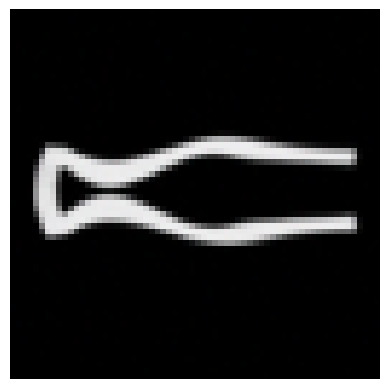

In [56]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

grid = make_grid(
    results[-1, -5:], padding=0, nrow=10
)
def tensor_to_image(tensor):
    return F.to_pil_image(tensor.clamp(0, 1))

img = tensor_to_image(grid)
plt.axis("off")
plt.imshow(img)
plt.show()

In [57]:
results.shape

torch.Size([50, 1, 3, 64, 64])

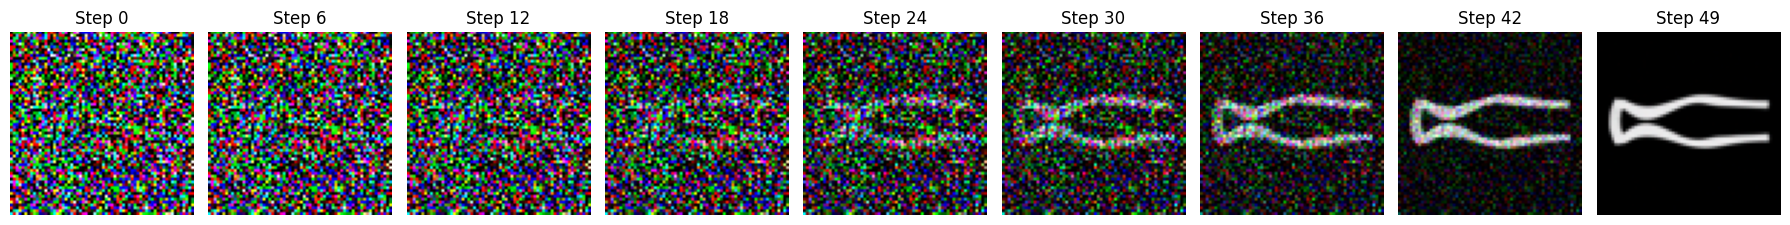

✅ Saved GIF to 'sample_0.gif'


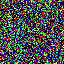

In [58]:
from IPython.display import display, Image as IPyImage

def show_and_save_sampling_progress(results, sample_idx=0, num_steps=9, save_path="sampling.gif", duration=300):
    """
    Hiển thị quá trình sampling (dạng ảnh) và đồng thời lưu thành file GIF.

    Args:
        traj (Tensor): Tensor 5D (T, B, C, H, W)
        sample_idx (int): Index của sample trong batch
        num_steps (int): Số bước sampling để hiển thị và lưu gif
        save_path (str): Đường dẫn file gif muốn lưu
        duration (int): Thời gian mỗi frame (milliseconds)
    """
    T = results.shape[0]
    assert num_steps <= T, "Số bước cần hiển thị phải nhỏ hơn hoặc bằng tổng số bước."

    # Lấy các bước cách đều từ 0 đến T-1
    indices = torch.linspace(0, T - 1, num_steps).long()

    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 6))
    frames = []

    for i, idx in enumerate(indices):
        img_tensor = results[idx, sample_idx]  # (C, H, W)
        pil_img = tensor_to_image(img_tensor.cpu())
        frames.append(pil_img)

        # Hiển thị bằng matplotlib
        axes[i].imshow(pil_img)
        axes[i].axis("off")
        axes[i].set_title(f"Step {idx.item()}")

    plt.tight_layout()
    plt.show()

    # Save GIF
    frames[0].save(
        save_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )
    print(f"✅ Saved GIF to '{save_path}'")

    display(IPyImage(filename=save_path))

sample_idx = 0
show_and_save_sampling_progress(results, sample_idx=sample_idx, num_steps=9, save_path=f"sample_{sample_idx}.gif")